### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**: 6

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape


((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [67]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

class Boosting:
    def __init__(
        self,
        base_model_params: dict = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        subsample: float = 0.3,
        early_stopping_rounds: int = None,
        plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params
        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)
        self.plot: bool = plot
        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def fit_new_base_model(self, x, y, predictions):
        bootstrap_indices = np.random.choice(np.arange(x.shape[0]), size=int(self.subsample * x.shape[0]))
        x_sample = x[bootstrap_indices]
        y_sample = y[bootstrap_indices]
        model = self.base_model_class(**self.base_model_params)
        model.fit(x_sample, self.loss_derivative(y_sample, predictions[bootstrap_indices]))
        gamma = self.find_optimal_gamma(y_sample, predictions[bootstrap_indices], model.predict(x_sample))
        self.gammas.append(gamma)
        self.models.append(model)
    def fit(self, x_train, y_train, x_valid, y_valid):
        train_predictions = np.zeros(y_train.shape[0], dtype=float)[:, None]
        valid_predictions = np.zeros(y_valid.shape[0], dtype=float)[:, None]
        for _ in range(self.n_estimators):
            self.fit_new_base_model(x_train, y_train, train_predictions[:, 0])
            train_predictions += self.learning_rate * self.models[-1].predict(x_train)[:, None]
            valid_predictions += self.learning_rate * self.models[-1].predict(x_valid)[:, None]
            train_loss = self.loss_fn(y_train, train_predictions[:, 0])
            valid_loss = self.loss_fn(y_valid, valid_predictions[:, 0])
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)
            if self.early_stopping_rounds is not None:
                if len(self.history['valid_loss']) >= self.early_stopping_rounds and \
                        valid_loss > np.min(self.history['valid_loss'][-self.early_stopping_rounds:]):
                    break
        if self.plot:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.history['train_loss'])), self.history['train_loss'], label='Train')
            plt.plot(range(len(self.history['valid_loss'])), self.history['valid_loss'], label='Valid')
            plt.xlabel('Number of iterations')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
    def predict_proba(self, x):
        predictions = np.zeros((x.shape[0], 2), dtype=float)
        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(x)[:, None]
        return self.sigmoid(predictions)
    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=-1, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]
    def score(self, x, y):
        return roc_auc_score(y, self.predict_proba(x)[:, 1])



In [117]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [5]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.8 s, sys: 11 ms, total: 1.81 s
Wall time: 2.3 s
Train ROC-AUC 0.9842
Valid ROC-AUC 0.9548
Test ROC-AUC 0.9533


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

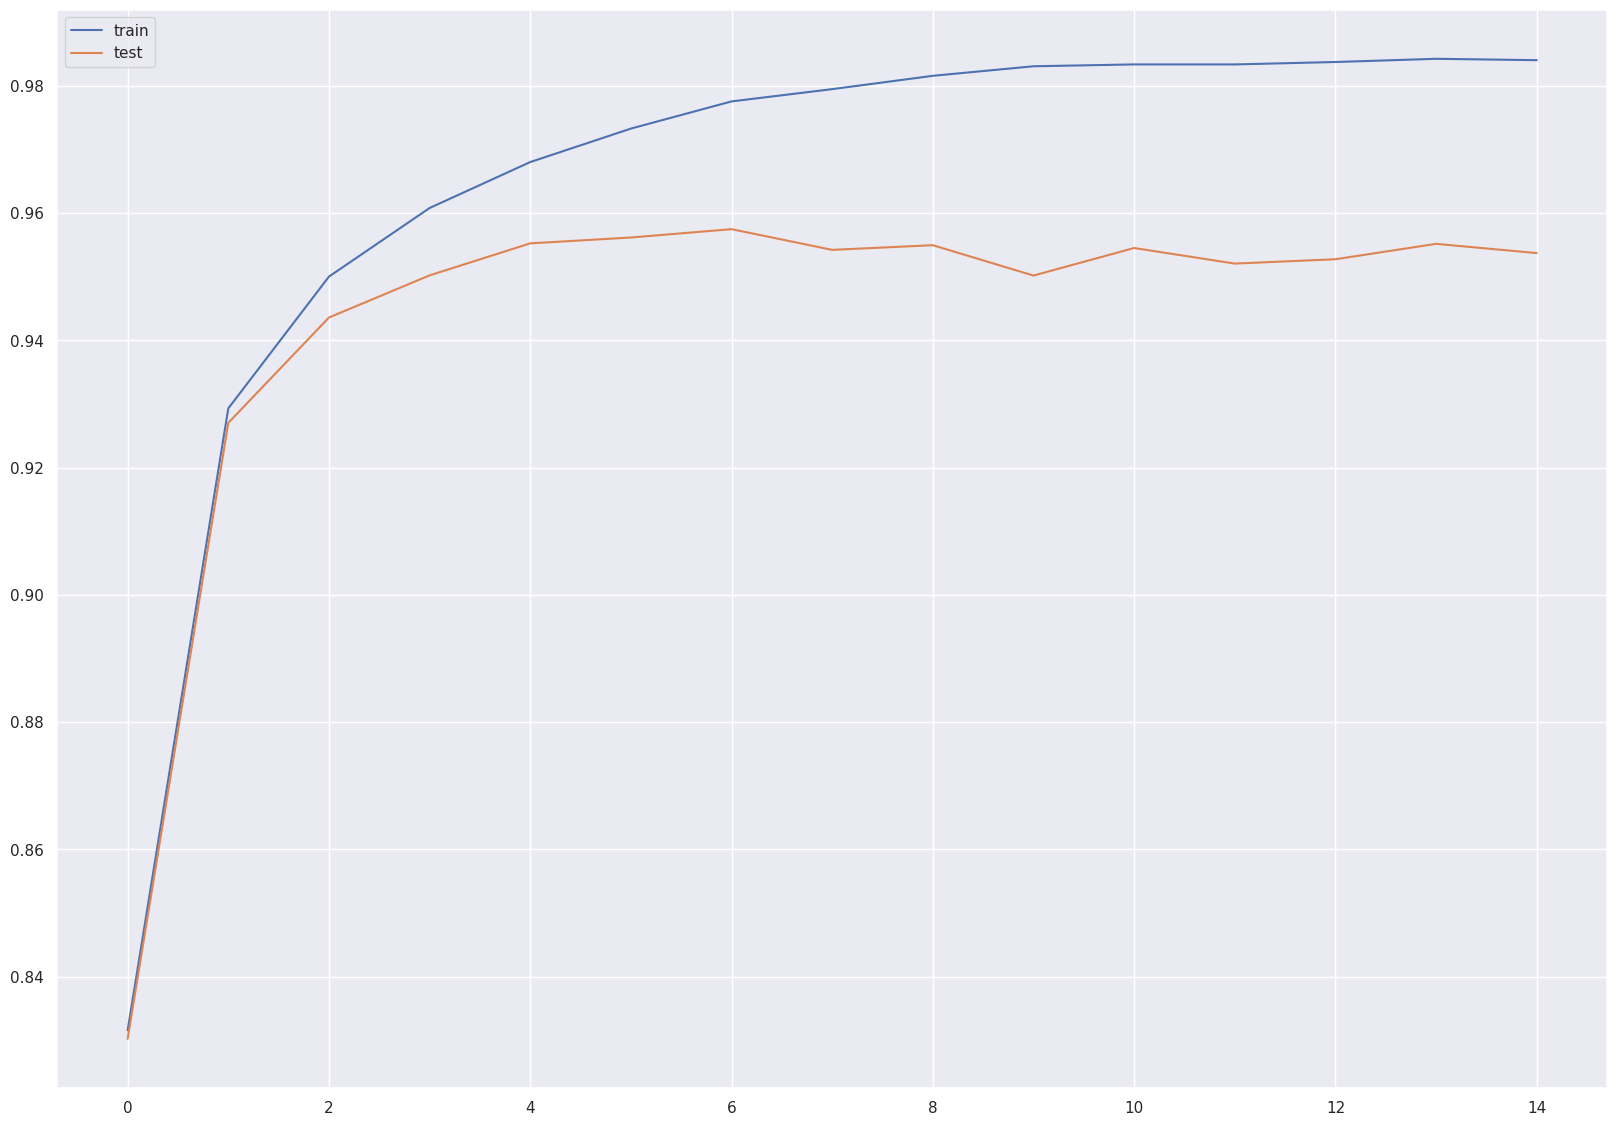

In [6]:
results = {'train' : [], 'test' : []}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params = {'max_depth': depth})
    boosting.fit(x_train, y_train, x_test, y_test)

    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))


plt.figure(figsize=(20,14))
plt.plot(results['train'], label='train')
plt.plot(results['test'], label='test')
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

1 и 2 модели имеют одинаковое качество обучения на тренировочной и тестовой выборках.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [7]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [8]:
def hyperopt_score(params):
    boosting = Boosting(**params)
    boosting.fit(x_train, y_train, x_test, y_test)
    score_ = boosting.score(x_valid, y_valid)
    print(score_, params)
    return -score_

In [33]:
parameters = {
            'base_model_params' : {
                'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
                'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 3, 4, 5]),
                'min_samples_split': hp.choice('min_samples_split', [1.0, 3, 4, 5, 10])
            },
            'n_estimators': hp.choice('n_estimators', range(10, 100)),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'learning_rate': hp.quniform('learning_rate', 0.1, 0.6, 0.05)
        }

best_ = fmin(fn=hyperopt_score, space=parameters, algo=tpe.suggest, max_evals=10)
print('best:')
print(best_)

0.8286507364576066
{'base_model_params': {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 1.0}, 'learning_rate': 0.5, 'n_estimators': 42, 'subsample': 0.55}
0.9533947969451213
{'base_model_params': {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}, 'learning_rate': 0.5, 'n_estimators': 43, 'subsample': 0.75}
0.8209857055160923
{'base_model_params': {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 1.0}, 'learning_rate': 0.30000000000000004, 'n_estimators': 22, 'subsample': 0.6000000000000001}
0.8209857055160923
{'base_model_params': {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 1.0}, 'learning_rate': 0.55, 'n_estimators': 19, 'subsample': 0.6000000000000001}
0.9582108445908589
{'base_model_params': {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}, 'learning_rate': 0.1, 'n_estimators': 13, 'subsample': 0.9500000000000001}
0.941919174587923
{'base_model_params': {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split

In [34]:
model_best = {
      'base_model_params' : {
          'max_depth': best_['max_depth'],
          'min_samples_leaf': best_['min_samples_leaf'],
          'min_samples_split':  best_['min_samples_split']
      },
      'n_estimators': best_['n_estimators'],
      'subsample': best_['subsample'],
      'learning_rate': best_['learning_rate']
}

## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [35]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

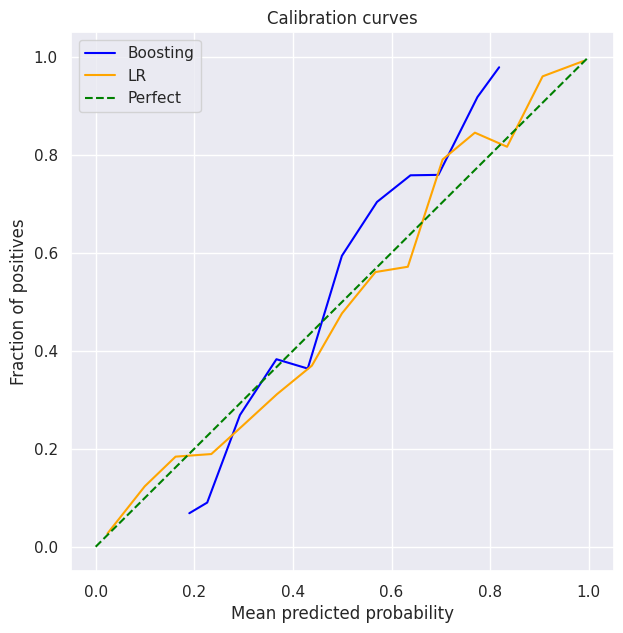

In [36]:
plt.figure(figsize=(7, 7))

bst_ = Boosting(**model_best)
bst_.fit(x_train, y_train, x_valid, y_valid)
bst_pred = bst_.predict_proba(x_test)[:, 1]

lr = LogisticRegression(max_iter=100000).fit(x_train, y_train)
lr_pred = lr.predict_proba(x_test)[:, 1]

bst_true_prob, bst_pred_prob = calibration_curve(y_test, bst_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(bst_pred_prob, bst_true_prob, label='Boosting', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

График логистической регрессии ближе к идеальной калибровочной прямой и заканчивается точно в точке (1.0, 1.0).

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

In [66]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

class Boosting:
    def __init__(
        self,
        base_model_params: dict = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        subsample: float = 0.3,
        early_stopping_rounds: int = None,
        plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params
        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)
        self.plot: bool = plot
        self.history = defaultdict(list)
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def fit_new_base_model(self, x, y, predictions):
        bootstrap_indices = np.random.choice(np.arange(x.shape[0]), size=int(self.subsample * x.shape[0]))
        x_sample = x[bootstrap_indices]
        y_sample = y[bootstrap_indices]
        model = self.base_model_class(**self.base_model_params)
        model.fit(x_sample, self.loss_derivative(y_sample, predictions[bootstrap_indices]))
        gamma = self.find_optimal_gamma(y_sample, predictions[bootstrap_indices], model.predict(x_sample))
        self.gammas.append(gamma)
        self.models.append(model)
    def fit(self, x_train, y_train, x_valid, y_valid):
        train_predictions = np.zeros(y_train.shape[0], dtype=float)[:, None]
        valid_predictions = np.zeros(y_valid.shape[0], dtype=float)[:, None]
        for _ in range(self.n_estimators):
            self.fit_new_base_model(x_train, y_train, train_predictions[:, 0])
            train_predictions += self.learning_rate * self.models[-1].predict(x_train)[:, None]
            valid_predictions += self.learning_rate * self.models[-1].predict(x_valid)[:, None]
            train_loss = self.loss_fn(y_train, train_predictions[:, 0])
            valid_loss = self.loss_fn(y_valid, valid_predictions[:, 0])
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)
            if self.early_stopping_rounds is not None:
                if len(self.history['valid_loss']) >= self.early_stopping_rounds and \
                        valid_loss > np.min(self.history['valid_loss'][-self.early_stopping_rounds:]):
                    break
        if self.plot:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.history['train_loss'])), self.history['train_loss'], label='Train')
            plt.plot(range(len(self.history['valid_loss'])), self.history['valid_loss'], label='Valid')
            plt.xlabel('Number of iterations')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
    def predict_proba(self, x):
        predictions = np.zeros((x.shape[0], 2), dtype=float)
        for model, gamma in zip(self.models, self.gammas):
            predictions += gamma * model.predict(x)[:, None]
        return self.sigmoid(predictions)
    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=-1, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]
    def score(self, x, y):
        return roc_auc_score(y, self.predict_proba(x)[:, 1])
    @property
    def feature_importances_(self):
        importances = np.zeros(self.models[0].feature_importances_.shape)
        for gamma, model in zip(self.gammas, self.models):
            importances += gamma * model.feature_importances_
        importances /= np.sum(importances)
        return importances

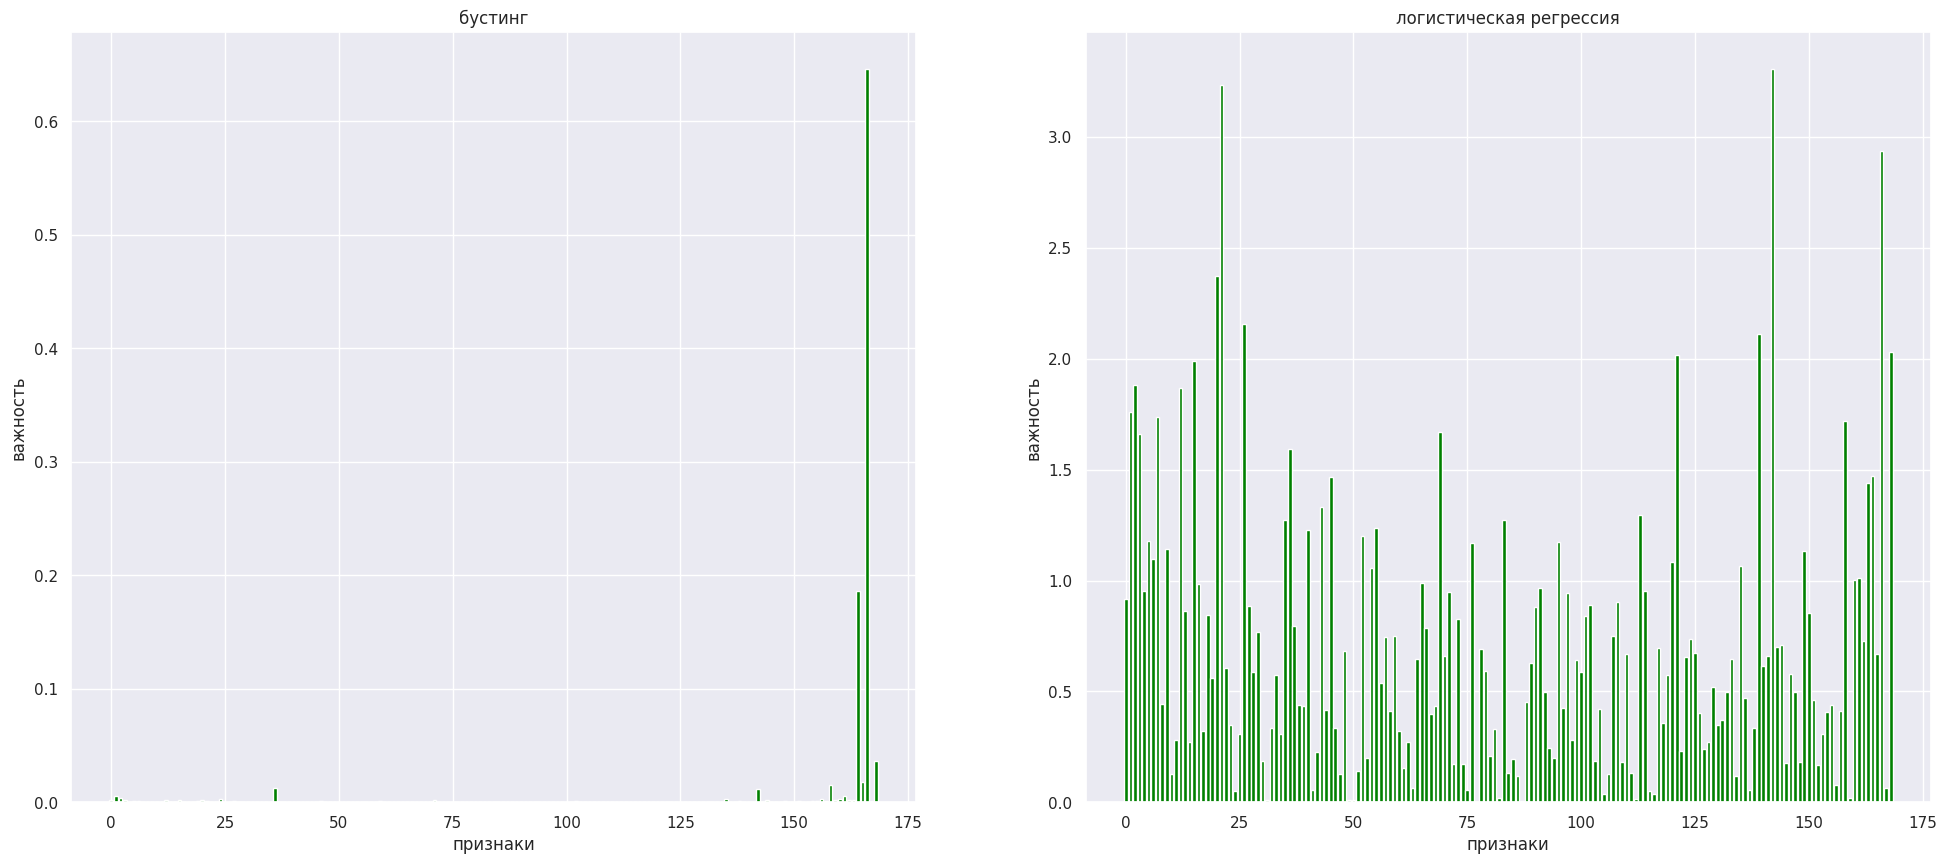

In [38]:
bst_ = Boosting(**model_best)
bst_.fit(x_train, y_train, x_valid, y_valid)  # Обучаем  модель

fig, ax = plt.subplots(1, 2, figsize=(24, 10))

ax[0].bar(np.arange(x_train.shape[1]), bst_.feature_importances_, color='green')
ax[0].set_xlabel('признаки')
ax[0].set_ylabel('важность')
ax[0].set_title('бустинг')

ax[1].bar(np.arange(x_train.shape[1]), abs(lr.coef_[0]), color='green')
ax[1].set_xlabel('признаки')
ax[1].set_ylabel('важность')
ax[1].set_title('логистическая регрессия')

plt.show()

Анализ результатов:

Градиентный бустинг:  

На графике видно, что у градиентного бустинга всего несколько важных признаков, и один из них имеет очень большое значение. Это говорит о том, что модель нашла сильную зависимость между этим признаком и целевой переменной.

Логистическая регрессия:

У логистической регрессии много важных признаков, причем их важность более равномерно распределена. Это может говорить о том, что модель нашла менее выраженные зависимости между различными признаками и целевой переменной.

Что это значит?

Градиентный бустинг более склонен фокусироваться на ключевых признаках, которые имеют сильную корреляцию с целевой переменной. Он может быть более эффективным при наличии нелинейных зависимостей в данных.

Логистическая регрессия учитывает все признаки, но не так сильно выделяет отдельные признаки. Она лучше подходит для линейных моделей и для данных с меньшим количеством нелинейных зависимостей.

Вывод:

Разница в важности признаков у градиентного бустинга и логистической регрессии отражает различие в способностях моделей улавливать зависимости в данных. Градиентный бустинг более гибкий и может более эффективно использовать сильные зависимости, в то время как логистическая регрессия более устойчива к шуму в данных.

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [39]:
boosting = Boosting(**model_best)
boosting.fit(x_train, y_train, x_test, y_test)
print('score with all features:', boosting.score(x_valid, y_valid))

score with all features: 0.9541638546682986


In [40]:
inds_ = []
for i in range(len(boosting.feature_importances_)):
  if boosting.feature_importances_[i] > 0.01:
    inds_.append(i)

In [41]:
boosting2 = Boosting(**model_best)
boosting2.fit(x_train[:, inds_], y_train, x_valid[:, inds_], y_valid)
print(boosting2.score(x_test[:, inds_], y_test))

0.9453239792222844


In [56]:
inds_ = []
for i in range(len(boosting.feature_importances_)):
  if boosting.feature_importances_[i] > 0.005:
    inds_.append(i)

In [57]:
boosting2 = Boosting(**model_best)
boosting2.fit(x_train[:, inds_], y_train, x_valid[:, inds_], y_valid)
print(boosting2.score(x_test[:, inds_], y_test))

0.9459125909582232


In [53]:
inds_ = []
for i in range(len(boosting.feature_importances_)):
  if boosting.feature_importances_[i] > 0.001:
    inds_.append(i)

In [54]:
boosting2 = Boosting(**model_best)
boosting2.fit(x_train[:, inds_], y_train, x_valid[:, inds_], y_valid)
print(boosting2.score(x_test[:, inds_], y_test))

0.9478224947586097


In [58]:
inds_ = []
for i in range(len(boosting.feature_importances_)):
  if boosting.feature_importances_[i] > 0.0005:
    inds_.append(i)

In [59]:
boosting2 = Boosting(**model_best)
boosting2.fit(x_train[:, inds_], y_train, x_valid[:, inds_], y_valid)
print(boosting2.score(x_test[:, inds_], y_test))

0.9515002236645


Качество модели не изменилось.

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [61]:
meta_X = list()
boosting = Boosting(**model_best)
boosting.fit(x_train, y_train, x_valid, y_valid)

yhat = boosting.predict_proba(x_valid)[:, 1]
yhat = yhat.reshape(len(yhat), 1)
meta_X.append(yhat)

meta_X = np.hstack(meta_X)

blender = LogisticRegression()
blender.fit(meta_X, y_valid)

meta_X = list()
yhat = boosting.predict_proba(x_test)[:, 1]
yhat = yhat.reshape(len(yhat), 1)
meta_X.append(yhat)
meta_X = np.hstack(meta_X)
res_pred = blender.predict(meta_X)

score = roc_auc_score(y_test, res_pred)

print(score)

0.8777653608162084


Качество модели ниже, чем было до этого.

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [62]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.3 MB/s eta 0:00:00


In [63]:
pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00


In [64]:
from catboost import CatBoost, Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [65]:
train_data = x_train

train_labels = y_train

test_data = catboost_pool = Pool(x_test,
                                 y_test)

model = CatBoostClassifier(iterations=2,
                           max_depth=best_['max_depth'],
                           learning_rate=best_['learning_rate'],
                           subsample=best_['subsample'])

model.fit(train_data, train_labels)
preds_class = model.predict(test_data)

print('score with CatBoostClassifier: ', roc_auc_score(preds_class, y_test))

0:	learn: 0.5794990	total: 65.3ms	remaining: 65.3ms
1:	learn: 0.5043446	total: 80.5ms	remaining: 0us
score with CatBoostClassifier:  0.8520099786172488


Качество модели, реализованной с помощью catboost, еще немного снизилось(0.85). Качество моей реализации получилось намного лучше (0.95).

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
